<a href="https://colab.research.google.com/github/SleeplessCoder09/Machine-Learning-with-Python/blob/main/Stock_Prediction_Using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [151]:
# IMPORTING IMPORTANT LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

from pandas_datareader import data as pdr
import yfinance as yf  
import datetime
from dateutil.relativedelta import relativedelta

In [152]:
# FOR REPRODUCIBILITY
np.random.seed(7)

In [153]:
# # IMPORTING DATASET 
# dataset = pd.read_csv('SKX.csv', usecols=['Open','High','Low','Close'])
# print(dataset)
# # dataset = pd.read_csv('apple_share_price.csv', usecols=[1,2,3,4])
# dataset = dataset.reindex(index = dataset.index[::-1])
# dataset = dataset[::-1]
# dataset
yf.pdr_override()
today = datetime.date.today() # - relativedelta(days=1)
three_yrs_ago = datetime.date.today() - relativedelta(years=3)
data = yf.download('TATAMOTORS.NS',three_yrs_ago,today)
# data = yf.Ticker('TSLA').history(period='max')
data.head()
data.tail()
dataset = data[['Open','High','Low','Close']]
dataset = dataset.reindex(index = dataset.index[::-1])
dataset = dataset[::-1]
data.tail()

2023-05-17
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-05-10,508.000000,512.900024,504.350006,509.500000,509.500000,12481404
2023-05-11,512.000000,514.150024,505.500000,511.600006,511.600006,11454020
2023-05-12,513.900024,520.500000,510.299988,515.950012,515.950012,19766717
2023-05-15,523.849976,537.150024,521.500000,530.849976,530.849976,38270067
2023-05-16,533.950012,535.950012,518.849976,521.150024,521.150024,16514882


In [129]:
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

In [130]:
# TAKING DIFFERENT INDICATORS FOR PREDICTION
OHLC_avg = dataset.mean(axis = 1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]
OHLC_avg

Date
2020-05-18     82.312500
2020-05-19     82.862501
2020-05-20     82.449999
2020-05-21     83.824999
2020-05-22     83.025002
                 ...    
2023-05-10    508.687508
2023-05-11    510.812508
2023-05-12    515.162506
2023-05-15    528.337494
2023-05-16    527.475006
Length: 746, dtype: float64

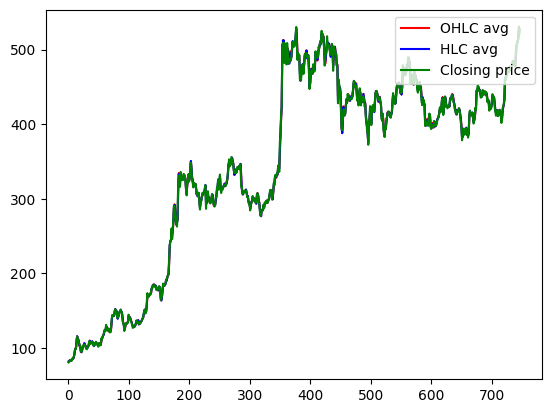

In [131]:
# PLOTTING ALL INDICATORS IN ONE PLOT
plt.plot(obs, OHLC_avg, 'r', label = 'OHLC avg')
plt.plot(obs, HLC_avg, 'b', label = 'HLC avg')
plt.plot(obs, close_val, 'g', label = 'Closing price')
plt.legend(loc = 'upper right')
plt.show()

In [132]:
# PREPARATION OF TIME SERIES DATASE
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1)) # 1664
scaler = MinMaxScaler(feature_range=(0, 5))
OHLC_avg = scaler.fit_transform(OHLC_avg)

In [133]:
# TRAIN-TEST SPLIT
train_OHLC = int(len(OHLC_avg) * 0.95)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

In [134]:
# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
def new_dataset(dataset, step_size):
	data_X, data_Y = [], []
	for i in range(len(dataset)-step_size-1):
		a = dataset[i:(i+step_size), 0]
		data_X.append(a)
		data_Y.append(dataset[i + step_size, 0])
	return np.array(data_X), np.array(data_Y)
trainX, trainY = new_dataset(train_OHLC, 1)
testX, testY = new_dataset(test_OHLC, 1)

In [135]:
def new_dataset(dataset, step_size):
	data_X, data_Y = [], []
	for i in range(len(dataset)-step_size-1):
		a = dataset[i:(i+step_size), 0]
		data_X.append(a)
		data_Y.append(dataset[i + step_size, 0])
	return np.array(data_X), np.array(data_Y)

In [136]:
print(trainX)

[[0.00000000e+00]
 [6.16558659e-03]
 [1.54138061e-03]
 [1.69553150e-02]
 [7.98723766e-03]
 [1.69553150e-02]
 [2.63438194e-02]
 [4.61016894e-02]
 [4.32991558e-02]
 [7.95919565e-02]
 [1.24152244e-01]
 [1.91553162e-01]
 [1.86228366e-01]
 [2.61896750e-01]
 [3.71896191e-01]
 [3.58163772e-01]
 [3.21310473e-01]
 [2.88520840e-01]
 [2.19438384e-01]
 [2.25884220e-01]
 [1.76559612e-01]
 [1.32699980e-01]
 [1.49795409e-01]
 [1.94075447e-01]
 [2.28826867e-01]
 [2.41158019e-01]
 [2.68482721e-01]
 [2.41998787e-01]
 [2.35272703e-01]
 [1.99120016e-01]
 [1.97158251e-01]
 [1.96597710e-01]
 [2.14113566e-01]
 [2.39616595e-01]
 [2.77871204e-01]
 [3.08979343e-01]
 [2.82074983e-01]
 [2.73527268e-01]
 [2.77590933e-01]
 [2.98609935e-01]
 [2.64699305e-01]
 [2.52368153e-01]
 [2.30368226e-01]
 [2.55170686e-01]
 [2.58813967e-01]
 [2.81374349e-01]
 [2.75769303e-01]
 [2.61756614e-01]
 [2.44941413e-01]
 [2.30508383e-01]
 [2.48584715e-01]
 [2.75208784e-01]
 [2.53349035e-01]
 [2.44100687e-01]
 [2.91743757e-01]
 [3.392466

In [137]:
print(trainY)

[6.16558659e-03 1.54138061e-03 1.69553150e-02 7.98723766e-03
 1.69553150e-02 2.63438194e-02 4.61016894e-02 4.32991558e-02
 7.95919565e-02 1.24152244e-01 1.91553162e-01 1.86228366e-01
 2.61896750e-01 3.71896191e-01 3.58163772e-01 3.21310473e-01
 2.88520840e-01 2.19438384e-01 2.25884220e-01 1.76559612e-01
 1.32699980e-01 1.49795409e-01 1.94075447e-01 2.28826867e-01
 2.41158019e-01 2.68482721e-01 2.41998787e-01 2.35272703e-01
 1.99120016e-01 1.97158251e-01 1.96597710e-01 2.14113566e-01
 2.39616595e-01 2.77871204e-01 3.08979343e-01 2.82074983e-01
 2.73527268e-01 2.77590933e-01 2.98609935e-01 2.64699305e-01
 2.52368153e-01 2.30368226e-01 2.55170686e-01 2.58813967e-01
 2.81374349e-01 2.75769303e-01 2.61756614e-01 2.44941413e-01
 2.30508383e-01 2.48584715e-01 2.75208784e-01 2.53349035e-01
 2.44100687e-01 2.91743757e-01 3.39246671e-01 3.59284811e-01
 3.83806958e-01 3.99501142e-01 4.45462674e-01 4.63118687e-01
 4.59895748e-01 5.16506895e-01 5.12443209e-01 4.64239683e-01
 4.80494365e-01 4.911440

In [138]:
# RESHAPING TRAIN AND TEST DATA
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1

In [139]:
# LSTM MODEL
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

In [140]:
# MODEL COMPILING AND TRAINING
model.compile(loss='mean_squared_error', optimizer='adagrad') # Try SGD, adam, adagrad and compare!!!
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
706/706 - 6s - loss: 9.2825 - 6s/epoch - 8ms/step
Epoch 2/50
706/706 - 2s - loss: 7.7504 - 2s/epoch - 3ms/step
Epoch 3/50
706/706 - 2s - loss: 6.1284 - 2s/epoch - 3ms/step
Epoch 4/50
706/706 - 2s - loss: 4.5033 - 2s/epoch - 3ms/step
Epoch 5/50
706/706 - 2s - loss: 3.1142 - 2s/epoch - 3ms/step
Epoch 6/50
706/706 - 3s - loss: 2.0770 - 3s/epoch - 4ms/step
Epoch 7/50
706/706 - 2s - loss: 1.3728 - 2s/epoch - 3ms/step
Epoch 8/50
706/706 - 2s - loss: 0.9232 - 2s/epoch - 3ms/step
Epoch 9/50
706/706 - 2s - loss: 0.6459 - 2s/epoch - 3ms/step
Epoch 10/50
706/706 - 2s - loss: 0.4779 - 2s/epoch - 3ms/step
Epoch 11/50
706/706 - 2s - loss: 0.3764 - 2s/epoch - 3ms/step
Epoch 12/50
706/706 - 3s - loss: 0.3140 - 3s/epoch - 4ms/step
Epoch 13/50
706/706 - 2s - loss: 0.2746 - 2s/epoch - 3ms/step
Epoch 14/50
706/706 - 2s - loss: 0.2488 - 2s/epoch - 3ms/step
Epoch 15/50
706/706 - 2s - loss: 0.2310 - 2s/epoch - 3ms/step
Epoch 16/50
706/706 - 2s - loss: 0.2178 - 2s/epoch - 3ms/step
Epoch 17/50
706/7

In [141]:
# PREDICTION
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

2/2 [==============================] - 0s 6ms/step


In [142]:
# trainY = scaler.inverse_transform(trainY)
trainY

array([6.16558659e-03, 1.54138061e-03, 1.69553150e-02, 7.98723766e-03,
       1.69553150e-02, 2.63438194e-02, 4.61016894e-02, 4.32991558e-02,
       7.95919565e-02, 1.24152244e-01, 1.91553162e-01, 1.86228366e-01,
       2.61896750e-01, 3.71896191e-01, 3.58163772e-01, 3.21310473e-01,
       2.88520840e-01, 2.19438384e-01, 2.25884220e-01, 1.76559612e-01,
       1.32699980e-01, 1.49795409e-01, 1.94075447e-01, 2.28826867e-01,
       2.41158019e-01, 2.68482721e-01, 2.41998787e-01, 2.35272703e-01,
       1.99120016e-01, 1.97158251e-01, 1.96597710e-01, 2.14113566e-01,
       2.39616595e-01, 2.77871204e-01, 3.08979343e-01, 2.82074983e-01,
       2.73527268e-01, 2.77590933e-01, 2.98609935e-01, 2.64699305e-01,
       2.52368153e-01, 2.30368226e-01, 2.55170686e-01, 2.58813967e-01,
       2.81374349e-01, 2.75769303e-01, 2.61756614e-01, 2.44941413e-01,
       2.30508383e-01, 2.48584715e-01, 2.75208784e-01, 2.53349035e-01,
       2.44100687e-01, 2.91743757e-01, 3.39246671e-01, 3.59284811e-01,
      

In [143]:
# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
trainY

array([[ 82.86250114,  82.44999886,  83.82499886,  83.02500153,
         83.82499886,  84.66250038,  86.42500114,  86.17500114,
         89.41250038,  93.38750076,  99.39999962,  98.92500114,
        105.67499924, 115.48749924, 114.26249886, 110.97500038,
        108.05000114, 101.88750076, 102.46250153,  98.0625    ,
         94.15000153,  95.67499924,  99.625     , 102.72500038,
        103.82500076, 106.26250076, 103.90000153, 103.30000114,
        100.07500076,  99.90000153,  99.84999847, 101.41250038,
        103.68749809, 107.10000038, 109.87500191, 107.47499847,
        106.71249962, 107.07499886, 108.94999886, 105.92500114,
        104.82500076, 102.86249733, 105.07500076, 105.39999962,
        107.41249847, 106.91250038, 105.66249847, 104.16249847,
        102.875     , 104.48749924, 106.86249924, 104.91250038,
        104.08750153, 108.33750153, 112.57499886, 114.36250114,
        116.54999924, 117.94999886, 122.04999733, 123.62500191,
        123.33749962, 128.38749695, 128.

In [144]:
# TRAINING RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))

Train RMSE: 24.41


In [145]:
# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

Test RMSE: 30.08


In [146]:
# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

In [147]:
# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

In [148]:
# DE-NORMALIZING MAIN DATASET 
OHLC_avg = scaler.inverse_transform(OHLC_avg)

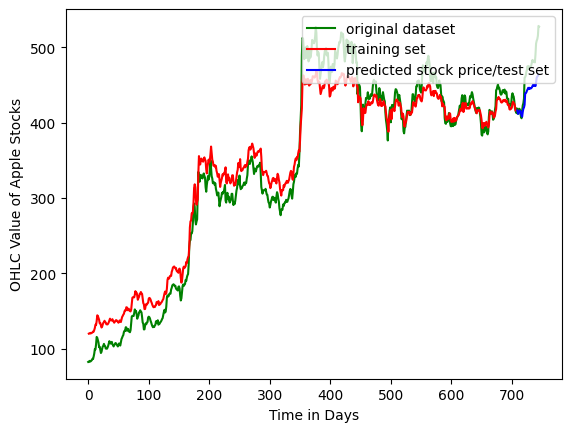

In [149]:
# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.plot(OHLC_avg, 'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of Apple Stocks')
plt.show()

In [150]:
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print("Last Day Value:", np.asscalar(last_val))
print("Next Day Value:", np.asscalar(last_val*next_val))

1/1 [==============================] - 0s 36ms/step
Last Day Value: 463.7935791015625
Next Day Value: 586.247314453125


<ipython-input-150-e92a4da7e878>:4: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  print("Last Day Value:", np.asscalar(last_val))
<ipython-input-150-e92a4da7e878>:5: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  print("Next Day Value:", np.asscalar(last_val*next_val))
